Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
#Download kernel data
!mkdir data
!kaggle datasets download neuromusic/avocado-prices -p ./data

In [2]:
#Libraries
import pandas as pd
import numpy as np
import re as re

#fastai v0.7.2
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
df_avocado = pd.read_csv('data/avocado.csv')

In [5]:
df_avocado.drop(list(df_avocado)[0], axis = 1, inplace = True)
df_avocado.drop(labels = 'year', axis = 1, inplace = True)

#convert to snake case
df_avocado.columns = [i.replace(" ", "_") for i in df_avocado.columns]
df_avocado.columns = [re.sub("(?<=[a-z])(?=[A-Z])", "_", i) for i in df_avocado.columns]
df_avocado.columns = [i.lower() for i in df_avocado.columns]

EDA

In [ ]:
df_avocado.head(5)

In [ ]:
df_avocado.dtypes

In [6]:
df_avocado['avo_type_sum'] = df_avocado['4046'] + df_avocado['4225'] + df_avocado['4770']

In [ ]:
#Sometimes the total volume differs

In [5]:
total_test = df_avocado['avo_type_sum'] + df_avocado['total_bags'] == df_avocado['total_volume']

In [ ]:
len(total_test)

In [ ]:
sum(total_test)

In [7]:
#Add seasonal variables
add_datepart(df_avocado, 'date', drop = True)

In [8]:
#convert to snake case
df_avocado.columns = [i.replace(" ", "_") for i in df_avocado.columns]
df_avocado.columns = [re.sub("(?<=[a-z])(?=[A-Z])", "_", i) for i in df_avocado.columns]
df_avocado.columns = [i.lower() for i in df_avocado.columns]

Modelling

In [ ]:
df_avocado.columns

In [9]:
#Convert variables to treat as categories for embeddings
factor_vars = [
    'region'
]

ordered_factors = ['year', 'month', 'week', 'day']

for f in factor_vars:
    df_avocado[f] = df_avocado[f].astype('category')
    
for f in ordered_factors:
    df_avocado[f] = df_avocado[f].astype('category').cat.as_ordered()

In [10]:
#Look at dims
[(c, len(df_avocado[c].cat.categories)) for c in factor_vars]

[('region', 54)]

In [12]:
#Convert type to bool
df_avocado['type'] = df_avocado['type'] == 'conventional'

In [13]:
#Convert all non-cat variables to float
cat_vars = (factor_vars + ordered_factors)

for f in df_avocado.columns:
    if(np.logical_not(np.isin(f, cat_vars))):
        df_avocado[f] = df_avocado[f].fillna(0).astype('float32')

In [14]:
#save to disk
df_avocado.to_feather('data/model_data')

In [15]:
#Create data split
train_idx = list(range(0, int(len(df_avocado) * .9)))
val_idx = list(range(int(len(df_avocado) * .8) + 1, int(len(df_avocado) * .9)))
test_idx = list(range(int(len(df_avocado) * .9) + 1, int(len(df_avocado))))

df_train = df_avocado.copy().iloc[train_idx]
# df_val = df_avocado.copy().iloc[val_idx]
df_test = df_avocado.copy().iloc[test_idx]

In [155]:
train, y, nas, mapper = proc_df(df_train, y_fld = 'average_price', do_scale=True)
test, y_test, nas, mapper =  proc_df(df_test, y_fld = 'average_price', do_scale=True, mapper=mapper, na_dict=nas)

In [17]:
yl = np.log(y)
train.head(5)

,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,region,...,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,elapsed
0,-0.240181,-0.243302,-0.214377,-0.224003,-0.242829,-0.241757,-0.228827,-0.185359,0.894256,1,...,27,0.0,1.719896,-0.176466,-0.195228,-0.072552,-0.102573,-0.072552,-0.072127,-0.568405
1,-0.242760,-0.243575,-0.222134,-0.223913,-0.242049,-0.240731,-0.228810,-0.185359,0.894256,1,...,20,0.0,1.654468,-0.176466,-0.195228,-0.072552,-0.102573,-0.072552,-0.072127,-0.589759
2,-0.225307,-0.243484,-0.171152,-0.223274,-0.243361,-0.242473,-0.228788,-0.185359,0.894256,1,...,13,0.0,1.589040,-0.176466,-0.195228,-0.072552,-0.102573,-0.072552,-0.072127,-0.611112
3,-0.236115,-0.243230,-0.200530,-0.223786,-0.245614,-0.245489,-0.228669,-0.185359,0.894256,1,...,6,0.0,1.523612,-0.176466,-0.195228,-0.072552,-0.102573,-0.072552,-0.072127,-0.632466
4,-0.243817,-0.243374,-0.222767,-0.223758,-0.245254,-0.245095,-0.228420,-0.185359,0.894256,1,...,29,0.0,1.458183,-0.176466,-0.195228,-0.072552,-0.102573,-0.072552,-0.072127,-0.653820


In [18]:
model_data = ColumnarModelData.from_data_frame('data/',  val_idx, train, yl.astype(np.float32),
                                  cat_flds = (factor_vars + ordered_factors), bs=128, test_df=test) 

In [20]:
cat_sz = [(c, len(df_avocado[c].cat.categories) + 1) for c in cat_vars]
cat_sz

[('region', 55), ('year', 5), ('month', 13), ('week', 54), ('day', 32)]

In [22]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(55, 28), (5, 3), (13, 7), (54, 27), (32, 16)]

In [40]:
train.dtypes

total_volume        float64
4046                float64
4225                float64
4770                float64
total_bags          float64
small_bags          float64
large_bags          float64
xlarge_bags         float64
type                float64
region                 int8
avo_type_sum        float64
year                   int8
month                  int8
week                   int8
day                    int8
dayofweek           float64
dayofyear           float64
is_month_end        float64
is_month_start      float64
is_quarter_end      float64
is_quarter_start    float64
is_year_end         float64
is_year_start       float64
elapsed             float64
dtype: object

In [109]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
m = model_data.get_learner(emb_szs, len(train.columns)-len(cat_vars),
                   0.04, 1, [20, 5], [0.05, .05], y_range=y_range)

In [104]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(55, 28)
    (1): Embedding(5, 3)
    (2): Embedding(13, 7)
    (3): Embedding(54, 27)
    (4): Embedding(32, 16)
  )
  (lins): ModuleList(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=5, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True)
    (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=5, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.05)
    (1): Dropout(p=0.05)
    (2): Dropout(p=0.05)
  )
  (bn): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True)
)

In [105]:
m.lr_find()

epoch      trn_loss   val_loss                                
    0      0.103759   0.126452  



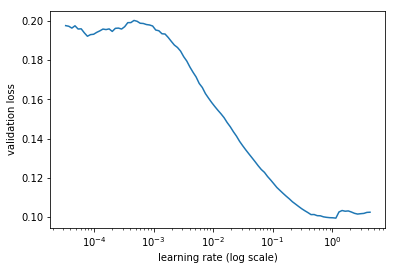

In [107]:
m.sched.plot(10)

In [111]:
lr = 1e-1
m.fit(lr, 2, cycle_len = 3, cycle_mult = 2)

epoch      trn_loss   val_loss                                
    0      0.036678   0.058198  
    1      0.03169    0.063899                                
    2      0.029358   0.058566                                 
    3      0.033301   0.064738                                
    4      0.032274   0.066096                                
    5      0.029361   0.062446                                
    6      0.027429   0.063022                                 
    7      0.027093   0.063206                                 
    8      0.025727   0.061681                                 



[array([0.06168])]

In [118]:
m.save('avo_model')

In [ ]:
#Look at pred accuracy

In [167]:
#Get predictions
pred_test = m.predict(True)

In [168]:
#Calculate error stats
test_eval = test.copy()
test_eval['actual'] = y_test
test_eval['pred'] = np.exp(pred_test)
test_eval['rmse'] = np.sqrt(np.power((test_eval['pred'] - test_eval['actual']) / test_eval['actual'], 2))
test_eval['smape'] = (abs(test_eval['actual'] - test_eval['pred'])) / ((abs(test_eval['actual']) + abs(test_eval['pred']))/2)

In [169]:
test_eval[['actual', 'pred', 'rmse', 'smape']]

,actual,pred,rmse,smape
16425,2.06,1.524639,0.259884,0.298698
16426,2.20,1.724463,0.216153,0.242345
16427,2.28,1.724463,0.243657,0.277459
16428,2.08,1.724463,0.170931,0.186905
16429,1.81,1.523266,0.158417,0.172044
16430,1.49,1.391683,0.065984,0.068236
16431,1.95,1.724463,0.115660,0.122759
16432,1.47,1.724463,0.173104,0.159315
16433,1.26,1.557282,0.235938,0.211042
16434,1.26,1.710507,0.357545,0.303320


In [170]:
np.mean(test_eval['smape'])

0.18296057

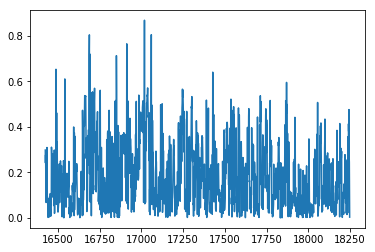

In [191]:
test_eval['smape'].plot()

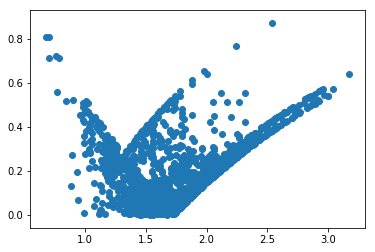

In [194]:
plt.figure()

plt.scatter(test_eval['actual'], test_eval['smape'])

Retry with RMSPE as an objective

In [185]:
#Retry with RMSE as the objective
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

m2 = model_data.get_learner(emb_szs, len(train.columns)-len(cat_vars),
                   0.04, 1, [20, 5], [0.001, 0.001], y_range=y_range)

In [186]:
m2.lr_find()

epoch      trn_loss   val_loss                                
    0      0.11496    0.312451  



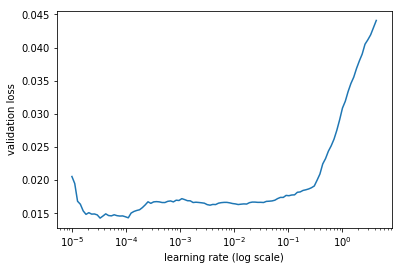

In [174]:
m2.sched.plot(0)

In [187]:
m2.fit(1e-5, 3, cycle_len = 2, cycle_mult = 2, metrics = [exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                    
    0      0.219811   0.094103   0.431958  
    1      0.215855   0.094031   0.431726                     
    2      0.216835   0.093644   0.430464                     
    3      0.215022   0.093344   0.429464                     
    4      0.21487    0.0932     0.428984                     
    5      0.212422   0.093177   0.428907                     
    6      0.210908   0.092716   0.427356                     
    7      0.206777   0.092256   0.425777                     
    8      0.206845   0.091849   0.424363                     
    9      0.205459   0.091525   0.42323                      
    10     0.201742   0.0913     0.42244                      
    11     0.200996   0.091171   0.421985                     
    12     0.199912   0.091122   0.421809                    
    13     0.20364    0.091114   0.421784                     



[array([0.09111]), 0.42178385455187883]

In [188]:
pred_test = m2.predict(True)

In [189]:
test_eval2 = test.copy()

test_eval2 = test.copy()
test_eval2['actual'] = y_test
test_eval2['pred'] = np.exp(pred_test)
test_eval2['rmse'] = np.sqrt(np.power((test_eval2['pred'] - test_eval2['actual']) / test_eval2['actual'], 2))
test_eval2['smape'] = (abs(test_eval2['actual'] - test_eval2['pred'])) / ((abs(test_eval2['actual']) + abs(test_eval2['pred']))/2)

In [190]:
np.mean(test_eval2['smape'])

0.20666312